# Utqiagvik **Spring Sea Ice** Analysis
- Bowhead whale hunting happens in spring (April/May) and is dependent on sea ice conditions (Hansen et al. 2013).
- Notebook by Alice DuVivier (NCAR)
- January 2026

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from glob import glob
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cmocean
import geopandas as gpd

## Load Data

In [2]:
# set model to load
# options: 'cesm1le', 'cesm2le', 'cesm2cmip5'
model = 'cesm2le'

In [3]:
# set base directory
dir_base = '/glade/campaign/cgd/ppc/duvivier/arctic_actionable/DATA/'

In [4]:
# set path for files

if model == 'cesm2le':
    dir_in = dir_base+'cesm2-le_utqiagvik/'
elif model == 'cesm1le':
    dir_in = dir_base+'cesm1-le_utqiagvik/'
elif model == 'cesm2cmip5':
    dir_in = dir_base+'cesm2-cmip5_utqiagvik/'

### Load model SIC data

In [5]:
# set file and then load data
if model == 'cesm2le':
    file_in = 'Utqiagvik_CESM2-LE_1920-2100_daily-aice_d.nc'
elif model == 'cesm2cmip5':
    file_in = 'Utqiagvik_CESM2-CMIP5_1920-2100_daily-aice_d.nc'           
elif model == 'cesm1le':
    file_in = 'Utqiagvik_CESM1-LE_1920-2100_daily-aice_d.nc'           

# load data
ds = xr.open_mfdataset(dir_in+file_in, decode_times=False)

In [6]:
# look at dataset
ds

# check out the time info - find that it's not intuitive
ds.time

# to make useable time coordinate, create arrays for yyyy-mm-dd (NO LEAP!)
# We know it's daily data for 19790101-20211231, not including leap days.

# create full range of dates at daily frequency
dr = pd.date_range(start='1/1/1920', end='12/31/2100', freq='D')
# remove leap days
dates = dr[(dr.day != 29) | (dr.month != 2)]
# check that the # times matches above
print(dates.shape)

# assign the time coordinate
ds['time'] = dates

(66065,)


In [7]:
# save this data, multiply by 100 if needed
if model == 'cesm2le':
    data_model_sic = ds.aice_d * 100.0
elif model == 'cesm1le':
    data_model_sic = ds.aice_d
elif model == 'cesm2cmip5':
    data_model_sic = ds.aice_d * 100.0

### Load model SIT data

In [8]:
# set file and then load data
if model == 'cesm2le':
    file_in = 'Utqiagvik_CESM2-LE_1920-2100_daily-hi_d.nc'
elif model == 'cesm2cmip5':
    file_in = 'Utqiagvik_CESM2-CMIP5_1920-2100_daily-hi_d.nc'           
elif model == 'cesm1le':
    file_in = 'Utqiagvik_CESM1-LE_1920-2100_daily-hi_d.nc'           

# load data
ds = xr.open_mfdataset(dir_in+file_in, decode_times=False)         

In [9]:
# look at dataset
ds

# check out the time info - find that it's not intuitive
ds.time

# to make useable time coordinate, create arrays for yyyy-mm-dd (NO LEAP!)
# We know it's daily data for 19790101-20211231, not including leap days.

# create full range of dates at daily frequency
dr = pd.date_range(start='1/1/1920', end='12/31/2100', freq='D')
# remove leap days
dates = dr[(dr.day != 29) | (dr.month != 2)]
# check that the # times matches above
print(dates.shape)

# assign the time coordinate
ds['time'] = dates

(66065,)


In [10]:
# save this data
data_model_sit = ds.hi_d

### Load model subgridscale ice data
- Need both aicen and vicen
- CESM1 has separate files for each category, but CESM2 they're all in one file. Need to adjust to fix this
- Note that this is monthly data, not daily

In [11]:
# total categories
ncat = 5

In [12]:
### aicen
# set file and then load data
if model == 'cesm2le':
    file_in = 'Utqiagvik_CESM2-LE_1920-2100_monthly-aicen.nc'
    # load data
    ds = xr.open_mfdataset(dir_in+file_in, decode_times=False)  
    # to make useable time coordinate, create arrays for yyyy-mm-dd (NO LEAP!)
    # We know it's daily data for 19790101-20211231, not including leap days.
    # create full range of dates at monthly frequency
    dates = pd.date_range(start='1/15/1920', end='1/15/2101', freq='M')
    # assign the time coordinate
    ds['time'] = dates
    # keep this data
    data_model_aicen = ds.aicen
elif model == 'cesm2cmip5':
    file_in = 'Utqiagvik_CESM2-CMIP5_1920-2100_monthly-aicen.nc'           
    # load data
    ds = xr.open_mfdataset(dir_in+file_in, decode_times=False)  
    # to make useable time coordinate, create arrays for yyyy-mm-dd (NO LEAP!)
    # We know it's daily data for 19790101-20211231, not including leap days.
    # create full range of dates at monthly frequency
    dates = pd.date_range(start='1/15/1920', end='1/15/2101', freq='M')
    # assign the time coordinate
    ds['time'] = dates
    # keep this data
    data_model_aicen = ds.aicen
elif model == 'cesm1le':
    # need to load five separate files and combine them
    file_in = 'Utqiagvik_CESM1-LE_1920-2100_monthly-aicen001.nc'
    ds_1 = xr.open_mfdataset(dir_in+file_in, decode_times=False)
    file_in = 'Utqiagvik_CESM1-LE_1920-2100_monthly-aicen002.nc'
    ds_2 = xr.open_mfdataset(dir_in+file_in, decode_times=False)
    file_in = 'Utqiagvik_CESM1-LE_1920-2100_monthly-aicen003.nc'
    ds_3 = xr.open_mfdataset(dir_in+file_in, decode_times=False)
    file_in = 'Utqiagvik_CESM1-LE_1920-2100_monthly-aicen004.nc'
    ds_4 = xr.open_mfdataset(dir_in+file_in, decode_times=False)
    file_in = 'Utqiagvik_CESM1-LE_1920-2100_monthly-aicen005.nc'
    ds_5 = xr.open_mfdataset(dir_in+file_in, decode_times=False)
    # total ensemble members
    nens = len(ds_1.member_id)
    # total time
    ntime = len(ds_1.time)
    # create full range of dates at monthly frequency
    dates = pd.date_range(start='1/15/1920', end='1/15/2101', freq='M')
    # put data into a single xarray - same format as other datasets
    array = np.zeros([nens,ntime,ncat])
    # fill with the data
    array[:,:,0] = ds_1['aicen001']/100.0
    array[:,:,1] = ds_2['aicen002']/100.0
    array[:,:,2] = ds_3['aicen003']/100.0
    array[:,:,3] = ds_4['aicen004']/100.0
    array[:,:,4] = ds_5['aicen005']/100.0
    # convert the numpy array to xarray
    data_model_aicen = xr.DataArray(array,dims=('member_id','time','nc'))
    data_model_aicen['time'] = dates
    data_model_aicen['member_id'] = ds_1.member_id


In [13]:
### vicen
# set file and then load data
if model == 'cesm2le':
    file_in = 'Utqiagvik_CESM2-LE_1920-2100_monthly-vicen.nc'
    # load data
    ds = xr.open_mfdataset(dir_in+file_in, decode_times=False)  
    # to make useable time coordinate, create arrays for yyyy-mm-dd (NO LEAP!)
    # We know it's daily data for 19790101-20211231, not including leap days.
    # create full range of dates at monthly frequency
    dates = pd.date_range(start='1/15/1920', end='1/15/2101', freq='M')
    # assign the time coordinate
    ds['time'] = dates
    # keep this data
    data_model_vicen = ds.vicen
elif model == 'cesm2cmip5':
    file_in = 'Utqiagvik_CESM2-CMIP5_1920-2100_monthly-vicen.nc'           
    # load data
    ds = xr.open_mfdataset(dir_in+file_in, decode_times=False)  
    # to make useable time coordinate, create arrays for yyyy-mm-dd (NO LEAP!)
    # We know it's daily data for 19790101-20211231, not including leap days.
    # create full range of dates at monthly frequency
    dates = pd.date_range(start='1/15/1920', end='1/15/2101', freq='M')
    # assign the time coordinate
    ds['time'] = dates
    # keep this data
    data_model_vicen = ds.vicen
elif model == 'cesm1le':
    # need to load five separate files and combine them
    file_in = 'Utqiagvik_CESM1-LE_1920-2100_monthly-vicen001.nc'
    ds_1 = xr.open_mfdataset(dir_in+file_in, decode_times=False)
    file_in = 'Utqiagvik_CESM1-LE_1920-2100_monthly-vicen002.nc'
    ds_2 = xr.open_mfdataset(dir_in+file_in, decode_times=False)
    file_in = 'Utqiagvik_CESM1-LE_1920-2100_monthly-vicen003.nc'
    ds_3 = xr.open_mfdataset(dir_in+file_in, decode_times=False)
    file_in = 'Utqiagvik_CESM1-LE_1920-2100_monthly-vicen004.nc'
    ds_4 = xr.open_mfdataset(dir_in+file_in, decode_times=False)
    file_in = 'Utqiagvik_CESM1-LE_1920-2100_monthly-vicen005.nc'
    ds_5 = xr.open_mfdataset(dir_in+file_in, decode_times=False)
    # total ensemble members
    nens = len(ds_1.member_id)
    # total time
    ntime = len(ds_1.time)
    # create full range of dates at monthly frequency
    dates = pd.date_range(start='1/15/1920', end='1/15/2101', freq='M')
    # put data into a single xarray - same format as other datasets
    array = np.zeros([nens,ntime,ncat])
    # fill with the data
    array[:,:,0] = ds_1['vicen001']
    array[:,:,1] = ds_2['vicen002']
    array[:,:,2] = ds_3['vicen003']
    array[:,:,3] = ds_4['vicen004']
    array[:,:,4] = ds_5['vicen005']
    # convert the numpy array to xarray
    data_model_vicen = xr.DataArray(array,dims=('member_id','time','nc'))
    data_model_vicen['time'] = dates
    data_model_vicen['member_id'] = ds_1.member_id


### Load Satellite SIC data

In [14]:
# directory path
dir_in = '/glade/campaign/cgd/ppc/duvivier/arctic_actionable/DATA/ssmi_cdr/'
file_in = 'Utqiagvik_SSMI_CDR_1979-2021_daily-SIC.nc'

ds = xr.open_mfdataset(dir_in+file_in, decode_times=False)

In [15]:
# look at dataset
#ds

# check out the time info - find that it's not intuitive
ds.time

# to make useable time coordinate, create arrays for yyyy-mm-dd (NO LEAP!)
# We know it's daily data for 19790101-20211231, not including leap days.

# create full range of dates at daily frequency
dr = pd.date_range(start='1/1/1979', end='12/31/2021', freq='D')
# remove leap days
dates = dr[(dr.day != 29) | (dr.month != 2)]
# check that the # times matches above
print(dates.shape)

# assign the time coordinate
ds['time'] = dates

(15695,)


In [16]:
data_obs_sic = ds.sic

### Load PIOMAS data

In [17]:
# directory path
dir_in = '/glade/campaign/cgd/ppc/duvivier/arctic_actionable/DATA/piomas/'
file_in = 'Utqiagvik_PIOMAS_1979-2019_daily-SIC.nc'

ds = xr.open_mfdataset(dir_in+file_in, decode_times=False)

In [18]:
# look at dataset
#ds

# check out the time info - find that it's not intuitive
ds.time

# to make useable time coordinate, create arrays for yyyy-mm-dd (NO LEAP!)
# We know it's daily data for 19790101-20211231, not including leap days.

# create full range of dates at daily frequency
dr = pd.date_range(start='1/1/1979', end='12/31/2019', freq='D')
# remove leap days
dates = dr[(dr.day != 29) | (dr.month != 2)]
# check that the # times matches above
print(dates.shape)

# assign the time coordinate
ds['time'] = dates

(14965,)


In [19]:
data_obs_sit = ds.sit

## Process Spring SIC data
- April and May only
- Timeseries: calculate means and standard deviations over all months

In [20]:
# days are all days in April and May
ndays = 30 + 31

### Satellite SIC

In [21]:
# years from 1979-2021
years_obs_sic = np.arange(1979,2022,1)
nyrs = len(years_obs_sic)
print(nyrs)

43


In [22]:
# subset data to just spring - April and May
avg_array = np.zeros([nyrs])
std_array = np.zeros([nyrs])

# loop through each year to get the data
for index, yy in enumerate(years_obs_sic):
    #print(f"Index {index}: {yy}")
    # get the data for this year
    temp1 = data_obs_sic.isel(time=data_obs_sic.time.dt.year.isin([yy]))
    # get spring months only
    temp2 = temp1.isel(time=temp1.time.dt.month.isin([3,4]))
    # calculate mean
    avg_array[index] = temp2.mean(dim='time')
    # calculate standard deviation
    std_array[index] = temp2.std(dim='time')

In [23]:
# convert the numpy arrays to xarrays for easier plotting
obs_sic_avg = xr.DataArray(avg_array,dims=('years'))
obs_sic_avg['years'] = years_obs_sic
obs_sic_std = xr.DataArray(std_array,dims=('years'))
obs_sic_std['years'] = years_obs_sic

### PIOMAS SIT

In [24]:
# years from 1979-2020
years_obs_sit = np.arange(1979,2020,1)
nyrs = len(years_obs_sit)
print(nyrs)

41


In [25]:
# subset data to just spring - April and May
avg_array = np.zeros([nyrs])
std_array = np.zeros([nyrs])

# loop through each year to get the data
for index, yy in enumerate(years_obs_sit):
    #print(f"Index {index}: {yy}")
    # get the data for this year
    temp1 = data_obs_sit.isel(time=data_obs_sit.time.dt.year.isin([yy]))
    # get spring months only
    temp2 = temp1.isel(time=temp1.time.dt.month.isin([3,4]))
    # calculate mean
    avg_array[index] = temp2.mean(dim='time')
    # calculate standard deviation
    std_array[index] = temp2.std(dim='time')

In [26]:
# convert the numpy arrays to xarrays for easier plotting
obs_sit_avg = xr.DataArray(avg_array,dims=('years'))
obs_sit_avg['years'] = years_obs_sit
obs_sit_std = xr.DataArray(std_array,dims=('years'))
obs_sit_std['years'] = years_obs_sit

## Process Spring SIC data - Model
- April and May only
- Timeseries: calculate means and standard deviations over spring months
- Time of Emergence: Use baseline 51 years (1925-1975). ToE happens when ensemble mean drops below the +/-2 STD from baseline period
- Fractions below some thresholds

In [27]:
# get some dimensions

# years from 1920-2100
years_model = np.arange(1920,2101,1)
nyrs = len(years_model)
print(nyrs)

# total ensemble members
nens = len(data_model_sic.member_id)
print(nens)

181
50


In [28]:
# subset to just this season
data_model_sic_seas = data_model_sic.isel(time=data_model_sic.time.dt.month.isin([3,4]))
data_model_sit_seas = data_model_sit.isel(time=data_model_sit.time.dt.month.isin([3,4]))
data_model_aicen_seas = data_model_aicen.isel(time=data_model_aicen.time.dt.month.isin([3,4]))
data_model_vicen_seas = data_model_vicen.isel(time=data_model_vicen.time.dt.month.isin([3,4]))

### Daily Data Means

In [29]:
# SIC
data_model = data_model_sic_seas

# preallocate some arrays
avg_array = np.zeros([nyrs])
std_array = np.zeros([nyrs])

# loop through each year to get the data
for index, yy in enumerate(years_model):
    #print(f"Index {index}: {yy}")
    # get the data for this year
    temp1 = data_model.isel(time=data_model.time.dt.year.isin([yy]))
    # make 1d
    temp2 = temp1.stack(all=("member_id","time"))
    # calculate mean
    avg_array[index] = temp2.mean(dim='all')
    # calculate standard deviation
    std_array[index] = temp2.std(dim='all')

# convert the numpy arrays to xarrays for easier plotting
data_model_sic_avg = xr.DataArray(avg_array,dims=('years'))
data_model_sic_avg['years'] = years_model
data_model_sic_std = xr.DataArray(std_array,dims=('years'))
data_model_sic_std['years'] = years_model

In [30]:
# SIT
data_model = data_model_sit_seas

# preallocate some arrays
avg_array = np.zeros([nyrs])
std_array = np.zeros([nyrs])

# loop through each year to get the data
for index, yy in enumerate(years_model):
    #print(f"Index {index}: {yy}")
    # get the data for this year
    temp1 = data_model.isel(time=data_model.time.dt.year.isin([yy]))
    # make 1d
    temp2 = temp1.stack(all=("member_id","time"))
    # calculate mean
    avg_array[index] = temp2.mean(dim='all')
    # calculate standard deviation
    std_array[index] = temp2.std(dim='all')

# convert the numpy arrays to xarrays for easier plotting
data_model_sit_avg = xr.DataArray(avg_array,dims=('years'))
data_model_sit_avg['years'] = years_model
data_model_sit_std = xr.DataArray(std_array,dims=('years'))
data_model_sit_std['years'] = years_model

### Time of Emergence
- For baseline, use 50 years: 1925-1975
- ToE happens when ensemble mean drops below the +/-2 STD from baseline period

In [31]:
# subset data to just 1925-1975
yy_sub = np.arange(1925,1976,1)

In [32]:
# SIC
data_model = data_model_sic_seas
model_avg = data_model_sic_avg

### Get baseline means and standard deviation
# subset years
data_model_sub = data_model.isel(time=data_model.time.dt.year.isin([yy_sub]))
# stack into one dimension
data_model_sub_1d = data_model_sub.stack(all=("member_id","time"))
# calculate mean and standard deviation over all these points
avg_baseline = data_model_sub_1d.mean(dim='all')
print(avg_baseline.values)
std_baseline = data_model_sub_1d.std(dim='all')
print(std_baseline.values)

### Find TOE
# When ensemble mean falls **below** baseline mean **minus** 2STD
toe_thresh_hi = avg_baseline + 2*std_baseline
toe_thresh_low = avg_baseline - 2*std_baseline
# make xarray of where the output has emerged
emerged = model_avg < toe_thresh_low.values
# Check if there is a ToE
is_all_false = (emerged == False).all()
# If there is a ToE, calculate the index where it happens
if is_all_false == False:
    print('ToE exists, calculating index')
    ToE_flag = True
    first_index = emerged.argmax(dim='years')
    # calculate x and y for plot
    x_toe = emerged[first_index].years.values
    y_toe = model_avg[first_index].values
    # print the year of ToE
    print(x_toe)
else:
    print('No ToE exists')
    ToE_flag = False
    x_toe = np.full((1, 1), np.nan)
    y_toe = np.full((1, 1), np.nan)

### Write variables
data_model_sic_x_toe = x_toe
data_model_sic_y_toe = y_toe
data_model_sic_toe_thresh_hi = toe_thresh_hi.values
data_model_sic_toe_thresh_low = toe_thresh_low.values

97.57427
5.957449
ToE exists, calculating index
2077


In [33]:
# SIT
data_model = data_model_sit_seas
model_avg = data_model_sit_avg

### Get baseline means and standard deviation
# subset years
data_model_sub = data_model.isel(time=data_model.time.dt.year.isin([yy_sub]))
# stack into one dimension
data_model_sub_1d = data_model_sub.stack(all=("member_id","time"))
# calculate mean and standard deviation over all these points
avg_baseline = data_model_sub_1d.mean(dim='all')
print(avg_baseline.values)
std_baseline = data_model_sub_1d.std(dim='all')
print(std_baseline.values)

### Find TOE
# When ensemble mean falls **below** baseline mean **minus** 2STD
toe_thresh_hi = avg_baseline + 2*std_baseline
toe_thresh_low = avg_baseline - 2*std_baseline
# make xarray of where the output has emerged
emerged = model_avg < toe_thresh_low.values
# Check if there is a ToE
is_all_false = (emerged == False).all()
# If there is a ToE, calculate the index where it happens
if is_all_false == False:
    print('ToE exists, calculating index')
    ToE_flag = True
    first_index = emerged.argmax(dim='years')
    # calculate x and y for plot
    x_toe = emerged[first_index].years.values
    y_toe = model_avg[first_index].values
    # print the year of ToE
    print(x_toe)
else:
    print('No ToE exists')
    ToE_flag = False
    x_toe = np.full((1, 1), np.nan)
    y_toe = np.full((1, 1), np.nan)

### Write variables
data_model_sit_x_toe = x_toe
data_model_sit_y_toe = y_toe
data_model_sit_toe_thresh_hi = toe_thresh_hi.values
data_model_sit_toe_thresh_low = toe_thresh_low.values

2.7497332
0.67234236
ToE exists, calculating index
2060


### Model: Fraction of days below thresholds

SIC thresholds
- Covered:  SIC>=85%
- MIZ:      15%<SIC<85%
- Ice free: SIC<15%

SIT thresholds
- SIT<1m
- SIT<2m
- Curry and Lopez 2020 say that a minimum of 3-4ft (1m-1.2m) ice thickness is needed for a whale

In [34]:
# SIC
times_tot = ndays*nens
data_model = data_model_sic_seas

# set thresholds
thresh1 = 85.0
thresh2 = 15.0

# loop through each year to calculate fractions
array_1 = np.zeros([nyrs])
array_2 = np.zeros([nyrs])

for index, yy in enumerate(years_model):
    #print(f"Index {index}: {yy}")
    # get data for this year
    temp1 = data_model.isel(time=data_model.time.dt.year.isin([yy]))
    # make 1d and put into the new array
    temp2 = temp1.stack(all=("member_id","time"))
    temp2 = temp2.compute()
    # count days with SIC<85% conditions
    count = len(temp2.where((temp2 < thresh1),drop=True))
    array_1[index] = 100.0*(count/times_tot)    
    # count days with SIC<15% conditions
    count = len(temp2.where((temp2 < thresh2),drop=True))
    array_2[index] = 100.0*(count/times_tot)

# convert the numpy arrays to xarrays for easier plotting
data_model_sic_thresh1 = xr.DataArray(array_1,dims=('years'))
data_model_sic_thresh1['years'] = years_model
data_model_sic_thresh2 = xr.DataArray(array_2,dims=('years'))
data_model_sic_thresh2['years'] = years_model

In [35]:
# SIT
times_tot = ndays*nens
data_model = data_model_sit_seas

# set thresholds
thresh1 = 2.0
thresh2 = 1.0

# loop through each year to calculate fractions
array_1 = np.zeros([nyrs])
array_2 = np.zeros([nyrs])

for index, yy in enumerate(years_model):
    #print(f"Index {index}: {yy}")
    # get data for this year
    temp1 = data_model.isel(time=data_model.time.dt.year.isin([yy]))
    # make 1d and put into the new array
    temp2 = temp1.stack(all=("member_id","time"))
    temp2 = temp2.compute()
    # count days with SIT<2m conditions
    count = len(temp2.where((temp2 < thresh1),drop=True))
    array_1[index] = 100.0*(count/times_tot)    
    # count days with SIT<1m conditions
    count = len(temp2.where((temp2 < thresh2),drop=True))
    array_2[index] = 100.0*(count/times_tot)

# convert the numpy arrays to xarrays for easier plotting
data_model_sit_thresh1 = xr.DataArray(array_1,dims=('years'))
data_model_sit_thresh1['years'] = years_model
data_model_sit_thresh2 = xr.DataArray(array_2,dims=('years'))
data_model_sit_thresh2['years'] = years_model

### Model subgridscale processing

In [36]:
# Spring mean ice fraction by category
# calculate annual average fractions of ice and open water area - average over both months and all ensemble members

data_model = data_model_aicen_seas

# preallocate some arrays
array_avg = np.zeros([nyrs,ncat])

# loop through each year to get the data
for index, yy in enumerate(years_model):
    #print(f"Index {index}: {yy}")
    # data
    temp = data_model.isel(time=data_model.time.dt.year.isin([yy]))
    array_avg[index,:] = temp.mean(dim=['member_id','time'])

# convert the numpy arrays to xarrays for easier use
data_model_aicen_avg = xr.DataArray(array_avg,dims=('years','nc'))
data_model_aicen_avg ['years'] = years_model

## Calculate the open ocean fraction from above
fracoo_model_avg = 1 - data_model_aicen_avg.sum(dim='nc')

In [37]:
## Spring ice thickness distribution

# set data we'll use
data_aicen = data_model_aicen_seas
data_vicen = data_model_vicen_seas

# calculate average thickness per category
hi = data_vicen/data_aicen

# preallocate some arrays
array_thick = np.zeros([nyrs,ncat,nens*2])
array_freq = np.zeros([nyrs,ncat,nens*2])

# loop through each year to get the data
for index, yy in enumerate(years_model):
    #print(f"Index {index}: {yy}")
    # get the thickness data
    temp = hi.isel(time=hi.time.dt.year.isin([yy]))
    array_thick[index,:,:] = temp.stack(all=("member_id","time"))
    # get the spatial frequency data
    temp = data_aicen.isel(time=data_aicen.time.dt.year.isin([yy]))
    array_freq[index,:,:] = temp.stack(all=("member_id","time"))

# convert the numpy arrays to xarrays for easier use
data_model_thick = xr.DataArray(array_thick,dims=('years','nc','all'))
data_model_thick ['years'] = years_model
data_model_freq = xr.DataArray(array_freq,dims=('years','nc','all'))
data_model_freq['years'] = years_model

In [38]:
## Decadal ice thickness distribution data

# set year ranges for each decade
# 1995: 1993-1997
yy1_1 = 1993
yy1_2 = 1997
# 2045: 2043-2047
yy2_1 = 2043
yy2_2 = 2047
# 2095: 2093-2097
yy3_1 = 2093
yy3_2 = 2097

# subset data by the three decades and stack so that all data is in one dimension
# decade 1
data_model_thick_dec1 = data_model_thick.where((data_model_thick.years >= yy1_1)&(data_model_thick.years <= yy1_2),drop=True).stack(npts=("years","all","nc"))
data_model_freq_dec1 = data_model_freq.where((data_model_freq.years >= yy1_1)&(data_model_freq.years <= yy1_2),drop=True).stack(npts=("years","all","nc"))
# decade 2
data_model_thick_dec2 = data_model_thick.where((data_model_thick.years >= yy2_1)&(data_model_thick.years <= yy2_2),drop=True).stack(npts=("years","all","nc"))
data_model_freq_dec2 = data_model_freq.where((data_model_freq.years >= yy2_1)&(data_model_freq.years <= yy2_2),drop=True).stack(npts=("years","all","nc"))
# decade 3
data_model_thick_dec3 = data_model_thick.where((data_model_thick.years >= yy3_1)&(data_model_thick.years <= yy3_2),drop=True).stack(npts=("years","all","nc"))
data_model_freq_dec3 = data_model_freq.where((data_model_freq.years >= yy3_1)&(data_model_freq.years <= yy3_2),drop=True).stack(npts=("years","all","nc"))

## Plots

In [39]:
# set an output directory for figures
dir_out = '/glade/campaign/cgd/ppc/duvivier/arctic_actionable/utqiagvik_analysis/version_5/'

In [40]:
# set colors 
if model == 'cesm2le':
    c1 = 'royalblue'
    c2 = 'lightskyblue'
    lab = 'CESM2-LE'
elif model == 'cesm1le':
    c1 = 'firebrick'
    c2 = 'pink'
    lab = 'CESM1-LE'
elif model == 'cesm2cmip5':
    c1 = 'gold'
    c2 = 'khaki'
    lab = 'CESM2-CMIP5'

# set colors for the fractional categories
cc = ['midnightblue','royalblue','cornflowerblue','skyblue','paleturquoise']

### All Panels on one Plot

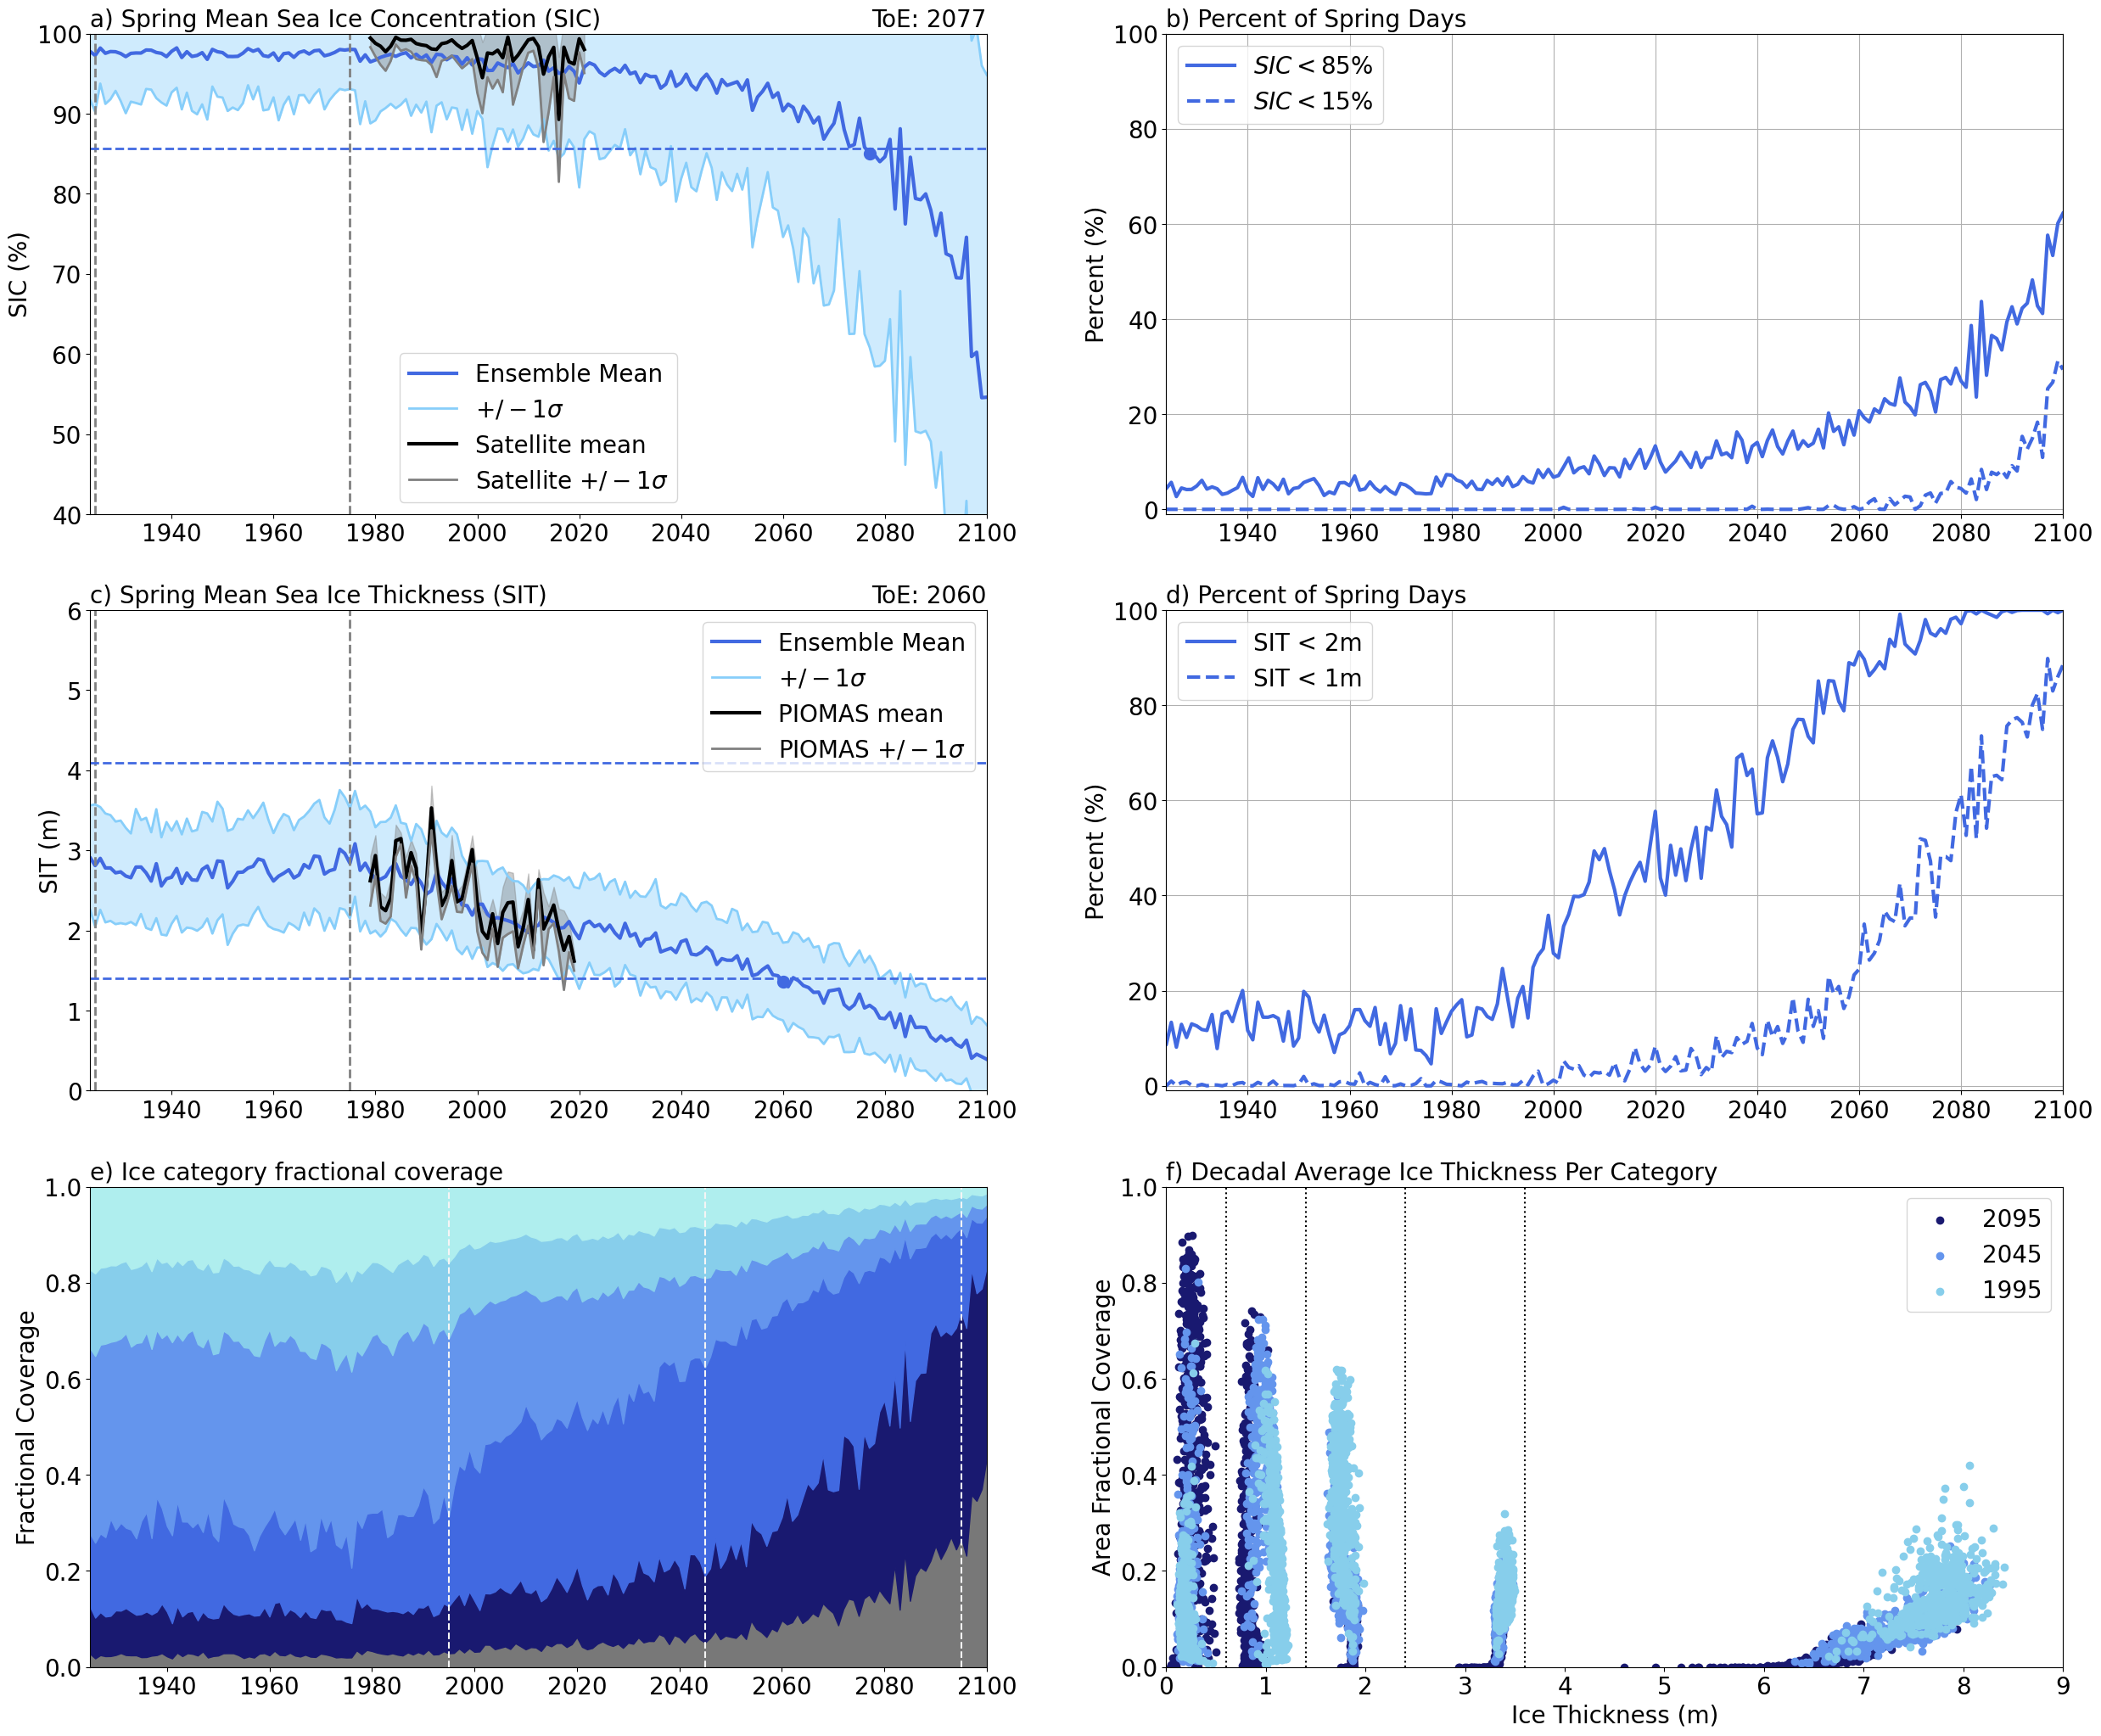

In [41]:
# create figure
fig = plt.figure(figsize=(30,25))

# Make subplot - note it's nrow x ncol x index (starting upper left) - 3 rows x 2 columns
### Plot 1 - SIC timeseries ###
ax = fig.add_subplot(3,2,1)
# data to plot
model_avg = data_model_sic_avg
model_std = data_model_sic_std
toe_x = data_model_sic_x_toe
toe_y = data_model_sic_y_toe
toe_hi = data_model_sic_toe_thresh_hi
toe_lo = data_model_sic_toe_thresh_low
toe = str(toe_x)
## Model Data
ax.plot(years_model,model_avg,color=c1,label='Ensemble Mean',linestyle='-',linewidth=3)
ax.plot(years_model,model_avg - model_std,color=c2,label=r'$+/- 1 \sigma$',linestyle='-',linewidth=2)
ax.plot(years_model,model_avg + model_std,color=c2,linestyle='-',linewidth=2)
plt.fill_between(years_model, model_avg, model_avg + model_std, color=c2, alpha=0.4)
plt.fill_between(years_model, model_avg, model_avg - model_std, color=c2, alpha=0.4)
## Satellite
ax.plot(years_obs_sic,obs_sic_avg,color="black",label='Satellite mean',linestyle='-',linewidth=3)
ax.plot(years_obs_sic,obs_sic_avg-obs_sic_std,color="grey",label=r'Satellite $ +/- 1 \sigma$',linestyle='-',linewidth=2)
plt.fill_between(years_obs_sic, obs_sic_avg, obs_sic_avg+obs_sic_std, color='grey', alpha=0.4)
plt.fill_between(years_obs_sic, obs_sic_avg, obs_sic_avg-obs_sic_std, color='grey', alpha=0.4)
## ToE values
plt.axvline(x=1925, color='grey', linestyle='--', linewidth=2)
plt.axvline(x=1975, color='grey', linestyle='--', linewidth=2)
plt.axhline(y=toe_hi, color=c1, linestyle='--', linewidth=2)
plt.axhline(y=toe_lo, color=c1, linestyle='--', linewidth=2)
plt.scatter(toe_x,toe_y, c=c1, marker="o",linewidth=5)
# modify labels and legend
plt.title('a) Spring Mean Sea Ice Concentration (SIC)',loc='left',fontsize=20)
plt.title('ToE: '+toe,loc='right',fontsize=20)
plt.xticks(fontsize=20,rotation=0)
plt.xlim([1924,2100])
plt.ylabel('SIC (%)',fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([40,100.0])
#plt.grid()
plt.legend(loc='lower center', fontsize=20, ncol=1)

### Plot 2  - SIC frequencies ###
ax = fig.add_subplot(3,2,2)
thresh1 = data_model_sic_thresh1
thresh2 = data_model_sic_thresh2
# Model Data
ax.plot(years_model,thresh1,color=c1,label=r'$SIC < 85\%$',linestyle='-',linewidth=3)
ax.plot(years_model,thresh2,color=c1,label=r'$SIC < 15\%$',linestyle='--',linewidth=3)
# modify labels and legend
plt.title('b) Percent of Spring Days',loc='left',fontsize=20)
plt.xticks(fontsize=20,rotation=0)
plt.xlim([1924,2100])
plt.ylabel('Percent (%)',fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([-1,100.0])
plt.grid()
plt.legend(loc='upper left', fontsize=20, ncol=1);

### Plot 3 - SIT timeseries ###
ax = fig.add_subplot(3,2,3)
# data to plot
model_avg = data_model_sit_avg
model_std = data_model_sit_std
toe_x = data_model_sit_x_toe
toe_y = data_model_sit_y_toe
toe_hi = data_model_sit_toe_thresh_hi
toe_lo = data_model_sit_toe_thresh_low
toe = str(toe_x)
## Model Data
ax.plot(years_model,model_avg,color=c1,label='Ensemble Mean',linestyle='-',linewidth=3)
ax.plot(years_model,model_avg - model_std,color=c2,label=r'$+/- 1 \sigma$',linestyle='-',linewidth=2)
ax.plot(years_model,model_avg + model_std,color=c2,linestyle='-',linewidth=2)
plt.fill_between(years_model, model_avg, model_avg + model_std, color=c2, alpha=0.4)
plt.fill_between(years_model, model_avg, model_avg - model_std, color=c2, alpha=0.4)
## PIOMAS
ax.plot(years_obs_sit,obs_sit_avg,color="black",label='PIOMAS mean',linestyle='-',linewidth=3)
ax.plot(years_obs_sit,obs_sit_avg-obs_sit_std,color="grey",label=r'PIOMAS $ +/- 1 \sigma$',linestyle='-',linewidth=2)
plt.fill_between(years_obs_sit, obs_sit_avg, obs_sit_avg+obs_sit_std, color='grey', alpha=0.4)
plt.fill_between(years_obs_sit, obs_sit_avg, obs_sit_avg-obs_sit_std, color='grey', alpha=0.4)
## ToE values
plt.axvline(x=1925, color='grey', linestyle='--', linewidth=2)
plt.axvline(x=1975, color='grey', linestyle='--', linewidth=2)
plt.axhline(y=toe_hi, color=c1, linestyle='--', linewidth=2)
plt.axhline(y=toe_lo, color=c1, linestyle='--', linewidth=2)
plt.scatter(toe_x,toe_y, c=c1, marker="o",linewidth=5)
# modify labels and legend
plt.title('c) Spring Mean Sea Ice Thickness (SIT)',loc='left',fontsize=20)
plt.title('ToE: '+toe,loc='right',fontsize=20)
#plt.xlabel('year',fontsize=20)
plt.xticks(fontsize=20,rotation=0)
plt.xlim([1924,2100])
plt.ylabel('SIT (m)',fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([0,6])
#plt.grid()
plt.legend(loc='upper right', fontsize=20, ncol=1)

### Plot 4  - SIT frequencies ###
ax = fig.add_subplot(3,2,4)
thresh1 = data_model_sit_thresh1
thresh2 = data_model_sit_thresh2
# Model Data
ax.plot(years_model,thresh1,color=c1,label='SIT < 2m',linestyle='-',linewidth=3)
ax.plot(years_model,thresh2,color=c1,label='SIT < 1m',linestyle='--',linewidth=3)
# modify labels and legend
plt.title('d) Percent of Spring Days',loc='left',fontsize=20)
plt.xticks(fontsize=20,rotation=0)
plt.xlim([1924,2100])
plt.ylabel('Percent (%)',fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([-1,100.0])
plt.grid()
plt.legend(loc='upper left', fontsize=20, ncol=1);

### Plot 5 - SIC category ###
ax = fig.add_subplot(3,2,5)
# open ocean first
ax.fill_between(years_model,np.zeros([nyrs]),fracoo_model_avg,color='dimgrey',alpha=0.9)
base = fracoo_model_avg
# all the ice categories next
for index, ii in enumerate(np.arange(1,6)):
    ax.fill_between(years_model,base,data_model_aicen_avg.isel(nc=index)+base,color=cc[index])
    base = data_model_aicen_avg.isel(nc=index) + base
# add decade lines
plt.axvline(x=1995, color='whitesmoke', linestyle='--')
plt.axvline(x=2045, color='whitesmoke', linestyle='--')
plt.axvline(x=2095, color='whitesmoke', linestyle='--')
# modify labels and legend
plt.title('e) Ice category fractional coverage',loc='left',fontsize=20)
plt.xticks(fontsize=20,rotation=0)
plt.xlim([1925,2100])
plt.ylabel('Fractional Coverage',fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([0,1.0])

### Plot 6  - SIT decadal frequencies ###
ax = fig.add_subplot(3,2,6)
# scatter plots
plt.scatter(data_model_thick_dec3,data_model_freq_dec3,color='midnightblue',label='2095')
plt.scatter(data_model_thick_dec2,data_model_freq_dec2,color='cornflowerblue',label='2045')
plt.scatter(data_model_thick_dec1,data_model_freq_dec1,color='skyblue',label='1995')
# add ice category
plt.axvline(x=0.6, color='black', linestyle=':')
plt.axvline(x=1.4, color='black', linestyle=':')
plt.axvline(x=2.4, color='black', linestyle=':')
plt.axvline(x=3.6, color='black', linestyle=':')
# modify labels and legend
plt.title('f) Decadal Average Ice Thickness Per Category',loc='left',fontsize=20)
plt.xlabel('Ice Thickness (m)',fontsize=20)
plt.xticks(fontsize=20)
plt.xlim([0,9.0])
plt.ylabel('Area Fractional Coverage',fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([0,1.0])
plt.legend(loc='upper right',fontsize=20)

### NEED TO ADD LEGENDS for bottom two plots!


# Finalize figure and save
#fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
#fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

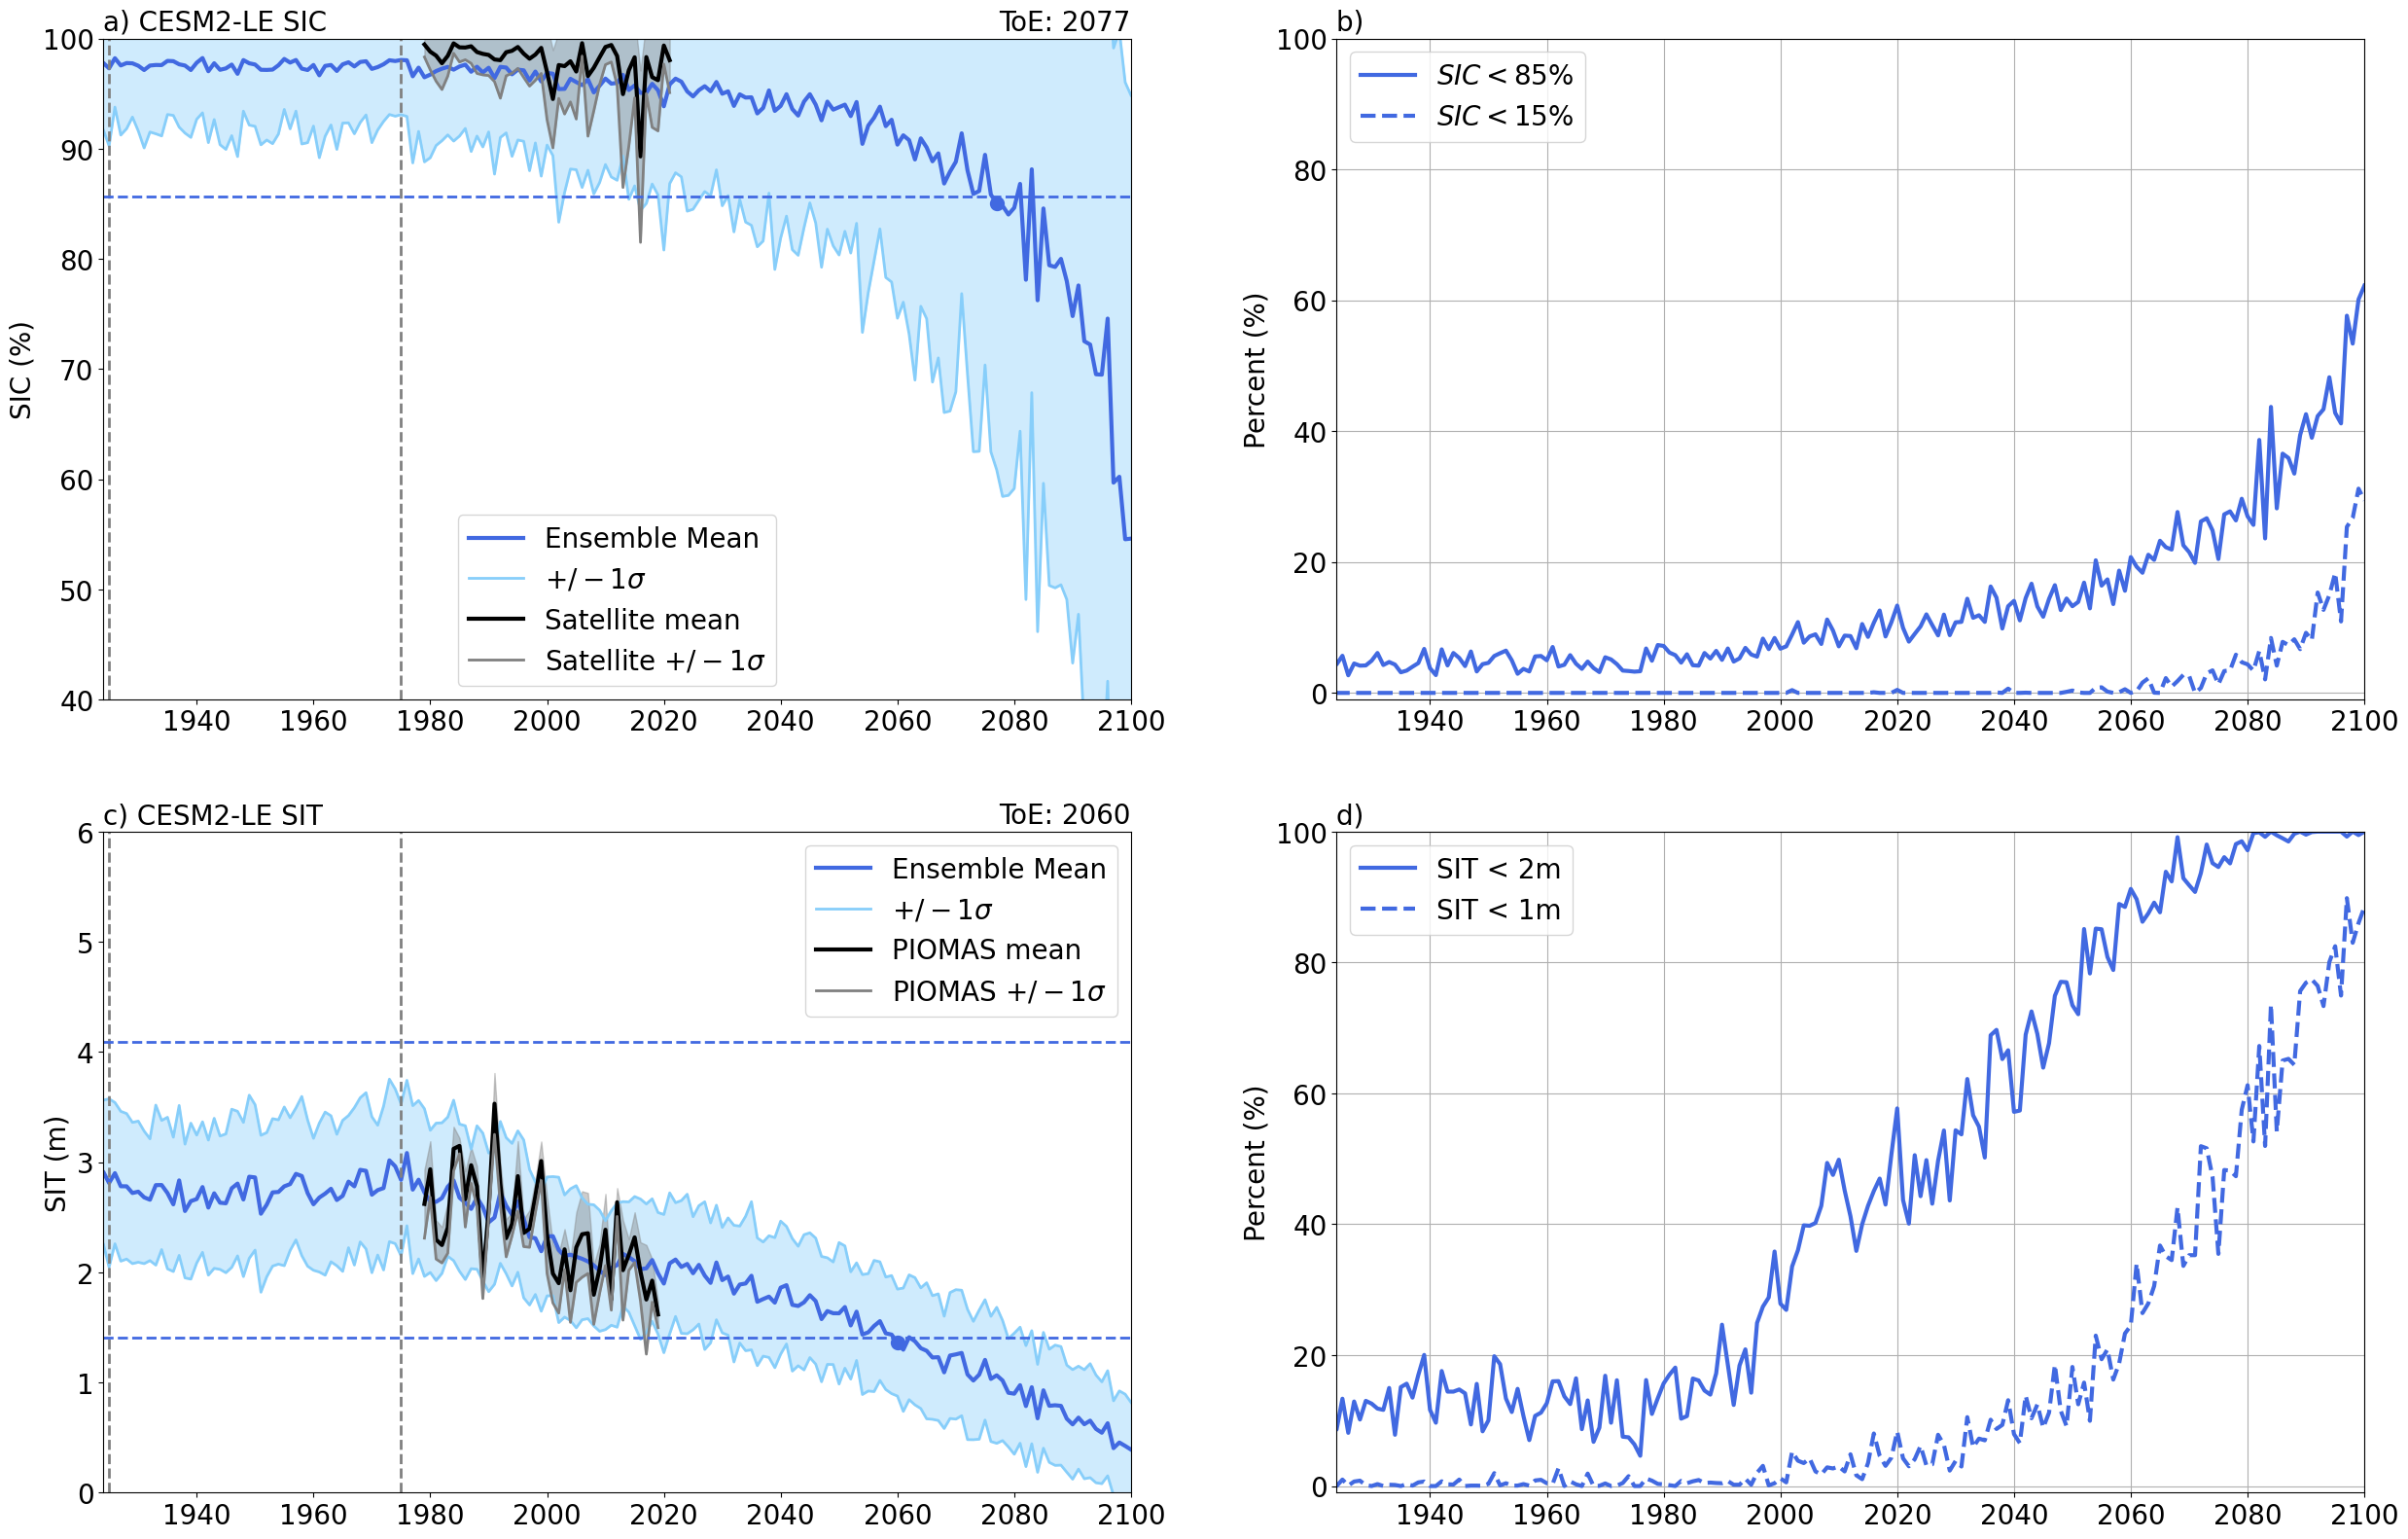

In [42]:
# create figure
fig = plt.figure(figsize=(30,30))
fout = 'fig3_utq_spring_sic_timeseries_'+model

# Make subplot - note it's nrow x ncol x index (starting upper left) - 3 rows x 2 columns
### Plot 1 - SIC timeseries ###
ax = fig.add_subplot(3,2,1)
# data to plot
model_avg = data_model_sic_avg
model_std = data_model_sic_std
toe_x = data_model_sic_x_toe
toe_y = data_model_sic_y_toe
toe_hi = data_model_sic_toe_thresh_hi
toe_lo = data_model_sic_toe_thresh_low
toe = str(toe_x)
## Model Data
ax.plot(years_model,model_avg,color=c1,label='Ensemble Mean',linestyle='-',linewidth=3)
ax.plot(years_model,model_avg - model_std,color=c2,label=r'$+/- 1 \sigma$',linestyle='-',linewidth=2)
ax.plot(years_model,model_avg + model_std,color=c2,linestyle='-',linewidth=2)
plt.fill_between(years_model, model_avg, model_avg + model_std, color=c2, alpha=0.4)
plt.fill_between(years_model, model_avg, model_avg - model_std, color=c2, alpha=0.4)
## Satellite
ax.plot(years_obs_sic,obs_sic_avg,color="black",label='Satellite mean',linestyle='-',linewidth=3)
ax.plot(years_obs_sic,obs_sic_avg-obs_sic_std,color="grey",label=r'Satellite $ +/- 1 \sigma$',linestyle='-',linewidth=2)
plt.fill_between(years_obs_sic, obs_sic_avg, obs_sic_avg+obs_sic_std, color='grey', alpha=0.4)
plt.fill_between(years_obs_sic, obs_sic_avg, obs_sic_avg-obs_sic_std, color='grey', alpha=0.4)
## ToE values
plt.axvline(x=1925, color='grey', linestyle='--', linewidth=2)
plt.axvline(x=1975, color='grey', linestyle='--', linewidth=2)
plt.axhline(y=toe_hi, color=c1, linestyle='--', linewidth=2)
plt.axhline(y=toe_lo, color=c1, linestyle='--', linewidth=2)
plt.scatter(toe_x,toe_y, c=c1, marker="o",linewidth=5)
# modify labels and legend
plt.title('a) CESM2-LE SIC',loc='left',fontsize=20)
plt.title('ToE: '+toe,loc='right',fontsize=20)
plt.xticks(fontsize=20,rotation=0)
plt.xlim([1924,2100])
plt.ylabel('SIC (%)',fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([40,100.0])
#plt.grid()
plt.legend(loc='lower center', fontsize=20, ncol=1)

### Plot 2  - SIC frequencies ###
ax = fig.add_subplot(3,2,2)
thresh1 = data_model_sic_thresh1
thresh2 = data_model_sic_thresh2
# Model Data
ax.plot(years_model,thresh1,color=c1,label=r'$SIC < 85\%$',linestyle='-',linewidth=3)
ax.plot(years_model,thresh2,color=c1,label=r'$SIC < 15\%$',linestyle='--',linewidth=3)
# modify labels and legend
plt.title('b) ',loc='left',fontsize=20)
plt.xticks(fontsize=20,rotation=0)
plt.xlim([1924,2100])
plt.ylabel('Percent (%)',fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([-1,100.0])
plt.grid()
plt.legend(loc='upper left', fontsize=20, ncol=1);

### Plot 3 - SIT timeseries ###
ax = fig.add_subplot(3,2,3)
# data to plot
model_avg = data_model_sit_avg
model_std = data_model_sit_std
toe_x = data_model_sit_x_toe
toe_y = data_model_sit_y_toe
toe_hi = data_model_sit_toe_thresh_hi
toe_lo = data_model_sit_toe_thresh_low
toe = str(toe_x)
## Model Data
ax.plot(years_model,model_avg,color=c1,label='Ensemble Mean',linestyle='-',linewidth=3)
ax.plot(years_model,model_avg - model_std,color=c2,label=r'$+/- 1 \sigma$',linestyle='-',linewidth=2)
ax.plot(years_model,model_avg + model_std,color=c2,linestyle='-',linewidth=2)
plt.fill_between(years_model, model_avg, model_avg + model_std, color=c2, alpha=0.4)
plt.fill_between(years_model, model_avg, model_avg - model_std, color=c2, alpha=0.4)
## PIOMAS
ax.plot(years_obs_sit,obs_sit_avg,color="black",label='PIOMAS mean',linestyle='-',linewidth=3)
ax.plot(years_obs_sit,obs_sit_avg-obs_sit_std,color="grey",label=r'PIOMAS $ +/- 1 \sigma$',linestyle='-',linewidth=2)
plt.fill_between(years_obs_sit, obs_sit_avg, obs_sit_avg+obs_sit_std, color='grey', alpha=0.4)
plt.fill_between(years_obs_sit, obs_sit_avg, obs_sit_avg-obs_sit_std, color='grey', alpha=0.4)
## ToE values
plt.axvline(x=1925, color='grey', linestyle='--', linewidth=2)
plt.axvline(x=1975, color='grey', linestyle='--', linewidth=2)
plt.axhline(y=toe_hi, color=c1, linestyle='--', linewidth=2)
plt.axhline(y=toe_lo, color=c1, linestyle='--', linewidth=2)
plt.scatter(toe_x,toe_y, c=c1, marker="o",linewidth=5)
# modify labels and legend
plt.title('c) CESM2-LE SIT',loc='left',fontsize=20)
plt.title('ToE: '+toe,loc='right',fontsize=20)
#plt.xlabel('year',fontsize=20)
plt.xticks(fontsize=20,rotation=0)
plt.xlim([1924,2100])
plt.ylabel('SIT (m)',fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([0,6])
#plt.grid()
plt.legend(loc='upper right', fontsize=20, ncol=1)

### Plot 4  - SIT frequencies ###
ax = fig.add_subplot(3,2,4)
thresh1 = data_model_sit_thresh1
thresh2 = data_model_sit_thresh2
# Model Data
ax.plot(years_model,thresh1,color=c1,label='SIT < 2m',linestyle='-',linewidth=3)
ax.plot(years_model,thresh2,color=c1,label='SIT < 1m',linestyle='--',linewidth=3)
# modify labels and legend
plt.title('d) ',loc='left',fontsize=20)
plt.xticks(fontsize=20,rotation=0)
plt.xlim([1924,2100])
plt.ylabel('Percent (%)',fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([-1,100.0])
plt.grid()
plt.legend(loc='upper left', fontsize=20, ncol=1);

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

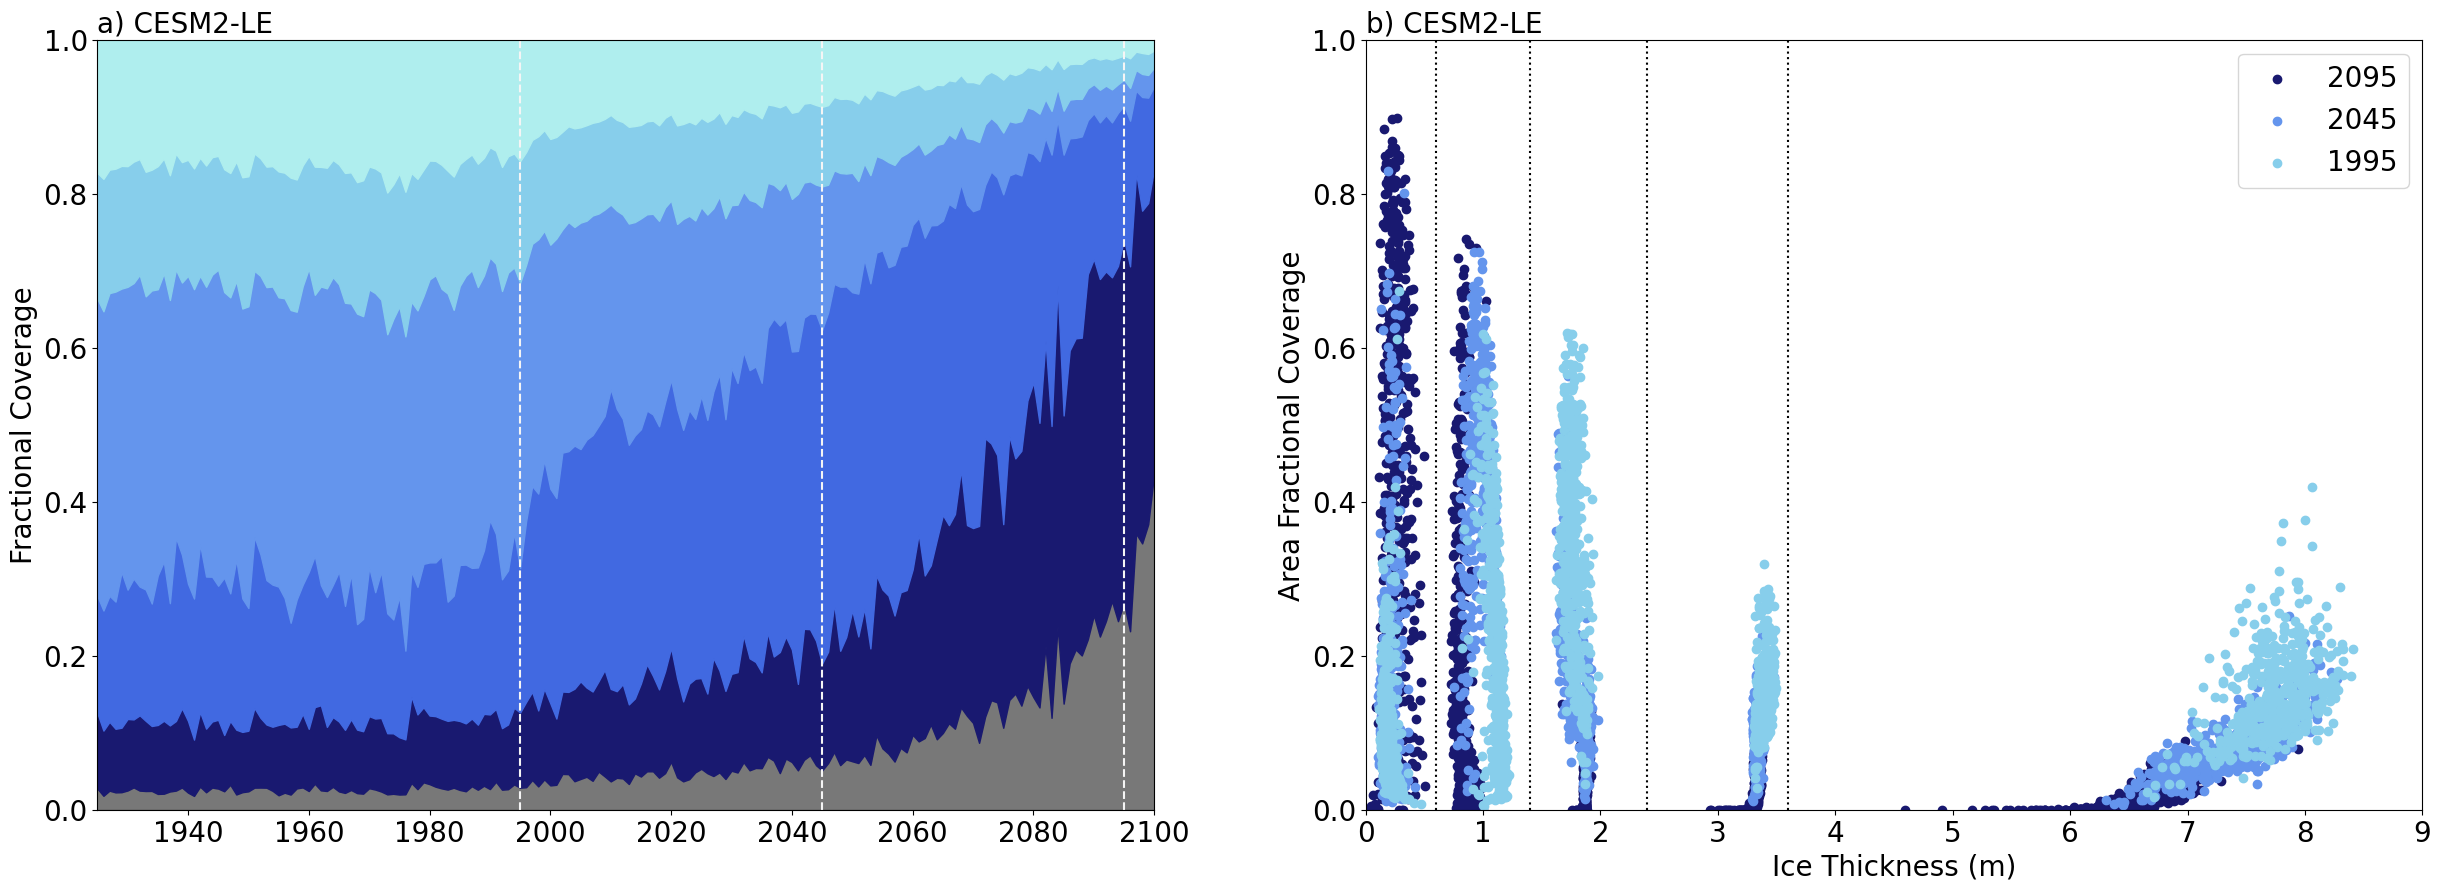

In [45]:
# create figure
fig = plt.figure(figsize=(30,10))
fout = 'fig4_utq_spring_itd_'+model

# Make subplot - note it's nrow x ncol x index (starting upper left) 
### Plot 1 - SIC category ###
ax = fig.add_subplot(1,2,1)
# open ocean first
ax.fill_between(years_model,np.zeros([nyrs]),fracoo_model_avg,color='dimgrey',alpha=0.9)
base = fracoo_model_avg
# all the ice categories next
for index, ii in enumerate(np.arange(1,6)):
    ax.fill_between(years_model,base,data_model_aicen_avg.isel(nc=index)+base,color=cc[index])
    base = data_model_aicen_avg.isel(nc=index) + base
# add decade lines
plt.axvline(x=1995, color='whitesmoke', linestyle='--')
plt.axvline(x=2045, color='whitesmoke', linestyle='--')
plt.axvline(x=2095, color='whitesmoke', linestyle='--')
# modify labels and legend
plt.title('a) CESM2-LE',loc='left',fontsize=20)
plt.xticks(fontsize=20,rotation=0)
plt.xlim([1925,2100])
plt.ylabel('Fractional Coverage',fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([0,1.0])

### Plot 2  - SIT decadal frequencies ###
ax = fig.add_subplot(1,2,2)
# scatter plots
plt.scatter(data_model_thick_dec3,data_model_freq_dec3,color='midnightblue',label='2095')
plt.scatter(data_model_thick_dec2,data_model_freq_dec2,color='cornflowerblue',label='2045')
plt.scatter(data_model_thick_dec1,data_model_freq_dec1,color='skyblue',label='1995')
# add ice category
plt.axvline(x=0.6, color='black', linestyle=':')
plt.axvline(x=1.4, color='black', linestyle=':')
plt.axvline(x=2.4, color='black', linestyle=':')
plt.axvline(x=3.6, color='black', linestyle=':')
# modify labels and legend
plt.title('b) CESM2-LE',loc='left',fontsize=20)
plt.xlabel('Ice Thickness (m)',fontsize=20)
plt.xticks(fontsize=20)
plt.xlim([0,9.0])
plt.ylabel('Area Fractional Coverage',fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([0,1.0])
plt.legend(loc='upper right',fontsize=20)

### NEED TO ADD LEGENDS for bottom two plots!

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)

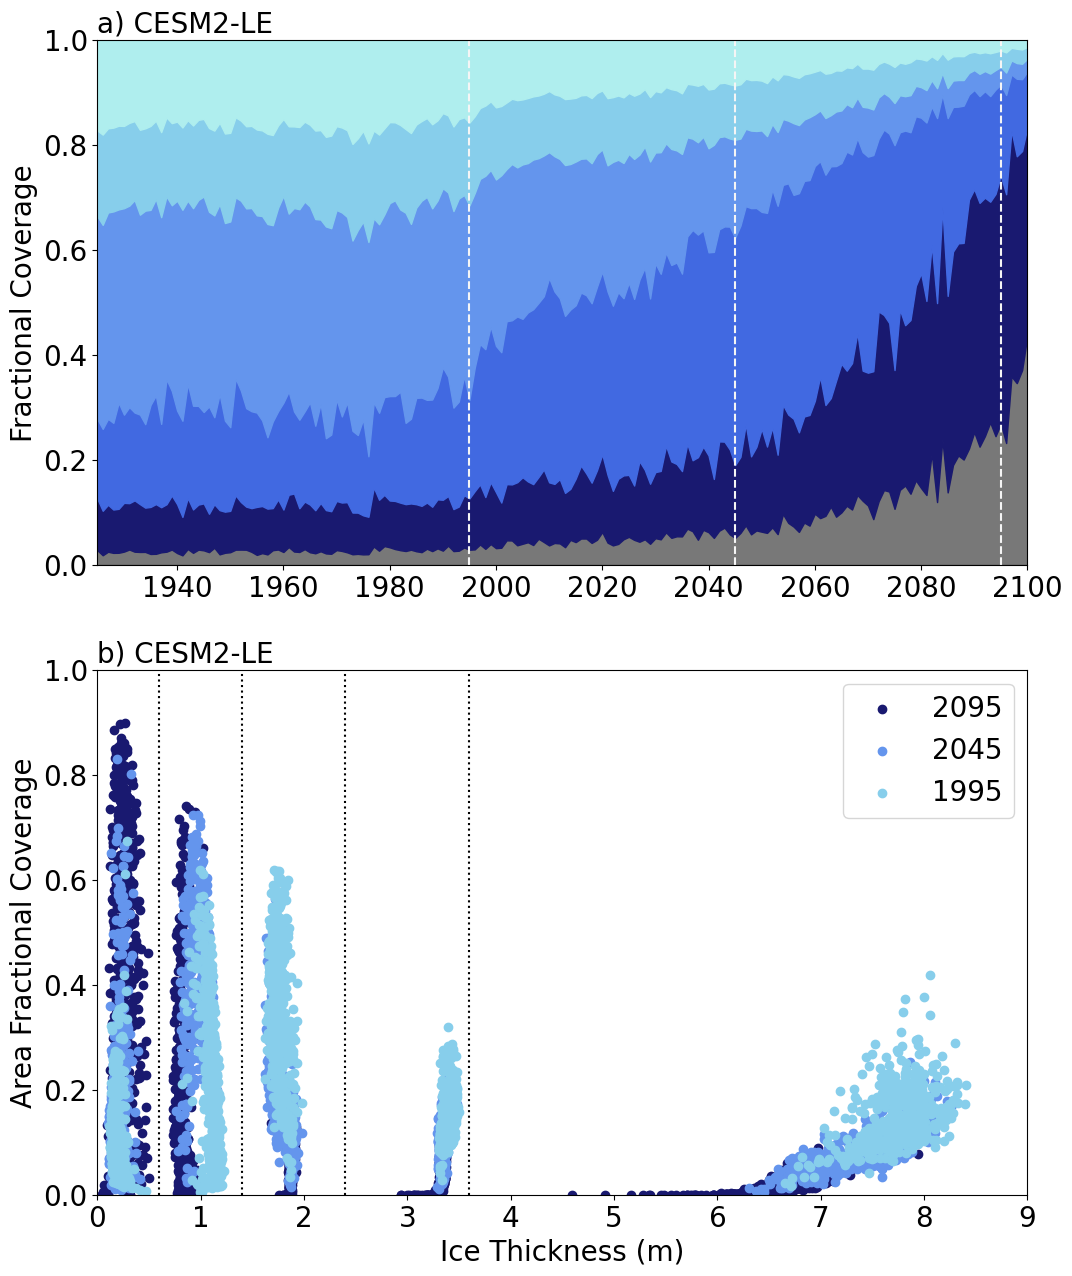

In [47]:
# create figure
fig = plt.figure(figsize=(12,15))
fout = 'fig4_utq_spring_itd_'+model

# Make subplot - note it's nrow x ncol x index (starting upper left) 
### Plot 1 - SIC category ###
ax = fig.add_subplot(2,1,1)
# open ocean first
ax.fill_between(years_model,np.zeros([nyrs]),fracoo_model_avg,color='dimgrey',alpha=0.9)
base = fracoo_model_avg
# all the ice categories next
for index, ii in enumerate(np.arange(1,6)):
    ax.fill_between(years_model,base,data_model_aicen_avg.isel(nc=index)+base,color=cc[index])
    base = data_model_aicen_avg.isel(nc=index) + base
# add decade lines
plt.axvline(x=1995, color='whitesmoke', linestyle='--')
plt.axvline(x=2045, color='whitesmoke', linestyle='--')
plt.axvline(x=2095, color='whitesmoke', linestyle='--')
# modify labels and legend
plt.title('a) CESM2-LE',loc='left',fontsize=20)
plt.xticks(fontsize=20,rotation=0)
plt.xlim([1925,2100])
plt.ylabel('Fractional Coverage',fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([0,1.0])

### Plot 2  - SIT decadal frequencies ###
ax = fig.add_subplot(2,1,2)
# scatter plots
plt.scatter(data_model_thick_dec3,data_model_freq_dec3,color='midnightblue',label='2095')
plt.scatter(data_model_thick_dec2,data_model_freq_dec2,color='cornflowerblue',label='2045')
plt.scatter(data_model_thick_dec1,data_model_freq_dec1,color='skyblue',label='1995')
# add ice category
plt.axvline(x=0.6, color='black', linestyle=':')
plt.axvline(x=1.4, color='black', linestyle=':')
plt.axvline(x=2.4, color='black', linestyle=':')
plt.axvline(x=3.6, color='black', linestyle=':')
# modify labels and legend
plt.title('b) CESM2-LE',loc='left',fontsize=20)
plt.xlabel('Ice Thickness (m)',fontsize=20)
plt.xticks(fontsize=20)
plt.xlim([0,9.0])
plt.ylabel('Area Fractional Coverage',fontsize=20)
plt.yticks(fontsize=20)
plt.ylim([0,1.0])
plt.legend(loc='upper right',fontsize=20)

### NEED TO ADD LEGENDS for bottom two plots!

# Finalize figure and save
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)
fig = plt.savefig(dir_out+fout+'.png', bbox_inches='tight', dpi=200)